# Example of a basic simulation done with pvpumpingsystem

## Introduction to photovoltaic pumping systems

To start with, let's have a look at what a PV pumping system is typically made of. The system can be divided in 5 major parts: PV generation, power electronics, motor-pump, pipes network and a reservoir. The PV generator converts
solar irradiance in electric power, whose characteristics can be modified by a power conditioning unit before entering the motor-pump. Then the motor-pump transfers water from the water source to the reservoir where it will stay until used.
![General schema of a PV pumping system](images/schema_pvps.jpg)

Note that the version 1.0 of this package focuses on small and medium size PVPS, for which DC motor-pumps are very common. Therefore modeling AC motor-pumps (which are used for more important flow-rates) and inverters is not yet possible, and power electronics limits to MPPT/DC-DC converters at the moment.

This package considers energy storage via the form of a reservoir. In a PVPS, a reservoir can ultimately do the same than a battery, that is to say provide water when the sun does not shine. That said, adding a battery at the level of the power-conditioning unit could be modeled as well, and is one feature to be developed in the future.

## Basic simulation

Let's consider a photovoltaic water pumping system (PVPS) installed near Tunis, Tunisia. In order to introduce the global structure of the code, a very simple pumping system is considered here: the system does not include reservoir, the prices are unknown, and the user only wants to know how much water will be pumped on a typical year with its system.

### Definition of the PVPS

In [1]:
import matplotlib.pyplot as plt

import pvpumpingsystem.pvgeneration as pvgen
import pvpumpingsystem.mppt as mppt
import pvpumpingsystem.pump as pp
import pvpumpingsystem.pipenetwork as pn
import pvpumpingsystem.pvpumpsystem as pvps

To set the power generation part, the weather file of the location must be imported first.
Energy Plus Weather files are the default format accepted for which a simple path can be given. These files can be found at https://energyplus.net/weather. Other formats can be used as well, including pvgis tmy, tmy2, tmy3, nsrdb psm3, and others. To this end, the corresponding functions from *pvlib* can be used (cf https://pvlib-python.readthedocs.io/en/stable/api.html#io-tools).
In this case, the closest .epw weather file is the one of Tunis, so it is imported.

Secondly, The PV array must be defined. The name has to be precised enough for the software to find it in the CEC PV module database (database updated every year at least). The number of PV modules and how they are connected together is then defined with ``modules_per_string`` and ``strings_in_parallel``.

Thirdly, the orientation of the PV array is selected. The option ``south_at_latitude_tilt`` sets the azimuth of the array to the south (if in northern hemisphere, north otherwise), and the tilt of the array at the latitude of the location (read from the weather file). This orientation is a common rule of thumb for optimising the yearly photovoltaic output of a fixed array.


In [2]:
pvgen1 = pvgen.PVGeneration(
    # Weather data path
    weather_data_and_metadata=(
        '../../pvpumpingsystem/data/weather_files/'
        'TUN_Tunis.607150_IWEC.epw'),

    # PV array parameters
    pv_module_name='Canadian Solar CS5C 80M',  # Name of pv module to model
    modules_per_string=4,
    strings_in_parallel=1,

    # Models used (check pvlib.modelchain for all available models)
    orientation_strategy='south_at_latitude_tilt',  # or 'flat' or None
    )


MPPT converter is simply defined as follows. Default efficiency is set at 96%.

In [3]:
mppt1 = mppt.MPPT(efficiency=0.96,
                  idname='PCA-120-BLS-M2'
                  )

The motor-pump has to be defined then. A limited database is natively available in ``pvpumpingsystem/data/pump_files``, but any other pump with sufficient specifications can be entered. For entering new pump data:
1) open the template available at: "/pvpumpingsystem/data/pump_files/0_template_for_pump_specs.txt"
2) write your specs (watch the units!),
3) save it under a new name (like "name_of_pump.txt"),
4) and close the file.

In [4]:
pump_sunpump = pp.Pump(path="../../pvpumpingsystem/data/pump_files/SCB_10_150_120_BL.txt")

Pipes network considered here has a static head (vertical distance between pump and pipes output) of 20m, a total length of 100m and a diameter of 5cm. This diameter is relatively important

In [5]:
pipes1 = pn.PipeNetwork(h_stat=20,  # static head [m]
                        l_tot=100,  # length of pipes [m]
                        diam=0.05,  # diameter [m]
                        material='plastic')

All components previously defined must be "assemble" now. That is also the moment to choose how to couple the system; directly or through a MPPT converter. If "direct" is chosen, the MPPT object declared will be ignored.

Note that assembling all the object at the last moment allows to define numerous objects before (for example: 2 different PV array set-up that can be called "pvgen1" and "pvgen2", 3 different pumps "pump1", "pump2", "pump3", etc), and to easily change the combinations to model then.

In [6]:
pvps1 = pvps.PVPumpSystem(pvgen1,
                          pump_sunpump,
                          coupling='direct',  # to adapt: 'mppt' or 'direct',
                          mppt=mppt1,
                          pipes=pipes1)
pvps1.run_model()

### Results

In [7]:
print(pvps1)
print('\ntotal water pumped in the year = ', pvps1.flow.Qlpm.sum())
print('\ndetails on second day of pumping = \n', pvps1.flow[24:47])

PVPSystem made of: 
pvgeneration: PV generator made of: 
pv module: Canadian_Solar_Inc__CS5C_80M
number of modules: 4
in: Location: 
  name: TUNIS
  latitude: 36.83
  longitude: 10.23
  altitude: 4.0
  tz: 1.0 
pump: name: SCB_10_150_120_BL
price: 1097.0
modeling method: arab)

total water pumped in the year =  18352.20075722044

details on second day of pumping = 
                                 Qlpm         I          V           P  \
2005-01-02 00:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 01:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 02:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 03:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 04:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 05:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 06:00:00+01:00   0.000000  0.000000   0.000000    0.000000   
2005-01-02 07:00:00+01:00   0.000000       NaN 

Numerous data can be extracted after the running of the code. Among the most relevant we can consult the effective irradiance received, the electric power used by the motor and the system output flow rate. Let's take a look at the second day of the simulation: 

Text(0.5, 1.0, 'Output flow-rate vs time')

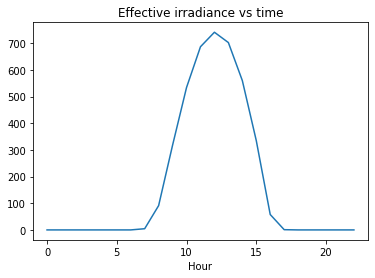

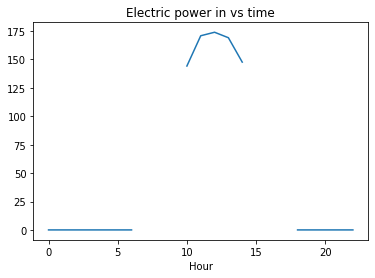

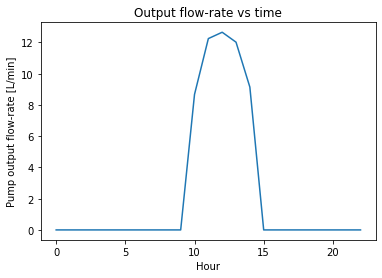

In [8]:
# effective irradiance on PV array
plt.figure()
plt.plot(pvps1.efficiency.index[24:47].hour,
         pvps1.pvgeneration.modelchain.effective_irradiance[24:47])
plt.xlabel('Hour')
plt.title('Effective irradiance vs time')
plt.xlim([-1,23])

# PV electric power
plt.figure()
plt.plot(pvps1.efficiency.index[24:47].hour,
         pvps1.efficiency.electric_power[24:47])
plt.xlabel('Hour')
plt.title('Electric power in vs time')

# Water volume in reservoir and output flow rate
plt.figure()
plt.plot(pvps1.efficiency.index[24:47].hour,
         pvps1.flow.Qlpm[24:47])
plt.xlabel('Hour')
plt.ylabel('Pump output flow-rate [L/min]')
plt.title('Output flow-rate vs time')

The first graph shows a typical sunny day. The irradiance constinuously increases until reaching its maximum around noon and decreases then.
The second graph shows the electrical power used by the pump. When at zero, it means that no power is generated from the PV generator. When NaN (no point on graph), there is power generated by the PV array but no operating point can be found with the motor-pump. When superior to zero, power is consumed by the pump and water flows.
The third graph shows the output flow-rate of the system. It can be noticed that water is actually pumped only between 10am and 2pm here.

### Direct or MPPT coupling?

Graph of match between PV array and motor-pump in the case of direct coupling. 
The 2 bended curves are from the PV array: the biggest is in ideal weather conditions whereas the smallest one represents poor weather conditions, therefore at any time during daytime the actual IV curve from PV array will typically be somewhere between these two curves.
The green line is the IV curve of the motor-pump. The more this curve is between the 2 others, the more the pump will works at any time of the day. If the match is particularly good, it can be interesting no to use any MPPT to save on its cost.

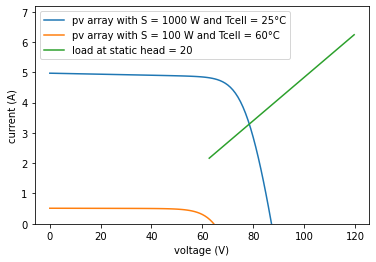

In [9]:
if pvps1.coupling == 'direct':
    pvps1.operating_point_noiteration(plot=True)